In [1]:
# Zemberek'i kullanabillmek için ilk önce java kütüphenelerini kullanmamızı sağlayan kütüphaneyi ekleyelim
import jpype
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java

In [2]:
# Zembrek'in jar dosyalarını okuyalım ve hangi modüller var bakalım
from zipfile import *
import zipfile

def read_jar(jar_file):
    zf = zipfile.ZipFile(jar_file, 'r')
    try:
        lst = zf.infolist()
        for zi in lst:
            fn = zi.filename 
    finally:
        zf.close()
        
read_jar("zemberek-full.jar")

In [3]:
# Zembrek'i çalıştıralım
jar = r"C:/Users/Dilemre/Documents/GitHub/bitirme/zemberek-full.jar" # Zemberek'in yolu
jvmpath = r"C:/Program Files/Java/jdk-17.0.2/bin/server/jvm.dll" # JVM'in yolu
if not jpype.isJVMStarted():
    jpype.startJVM(jvmpath=jvmpath, classpath=jar)
    print("ok")

ok


In [4]:
# Zemberekten gerekili kütüphaneleri import edelim
try:
    TurkishTokenizer = JClass('zemberek.tokenization.TurkishTokenizer')
    Token = JClass('zemberek.tokenization.Token')
    TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
    TurkishSpellChecker = JClass('zemberek.normalization.TurkishSpellChecker')
    WordAnalysis =  JClass('zemberek.morphology.analysis.WordAnalysis')
    TurkishSentenceExtractor = JClass('zemberek.tokenization.TurkishSentenceExtractor')
except:
    print("wrong path")

In [5]:
morphology = TurkishMorphology.createWithDefaults()
tokenizer = TurkishTokenizer.ALL
spell_checker = TurkishSpellChecker(morphology)
extractor = TurkishSentenceExtractor.DEFAULT

In [6]:
#Verilerimizi almak ve işlemek için gerekli kütüphaneler
import pandas as pd
import numpy as np
import string

In [7]:
stopwords = [x.strip() for x in open('stop-words.txt','r', encoding="UTF8").read().split('\n')]
df = pd.read_csv("ndata.csv")
df

,info,title,caption,link,text
0,"19 Mart 2021, Cuma",MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...
1,"18 Mart 2021, Perşembe",MEHMET BARLAS,Amerikan iç politikasında kimin kimi hedef ala...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nAmerikan iç politikasındaki gelişmeler kes...
2,"17 Mart 2021, Çarşamba",MEHMET BARLAS,"Amerikalılar, yalancı Amerikan başkanlarını ar...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nBugüne kadar her konuda Yunanistan'ın ve K...
3,"16 Mart 2021, Salı",MEHMET BARLAS,Darbeler geçmişte Türkiye’nin dış politikasını...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,"\n\nMısır'la diplomatik ilişkilerin başlaması,..."
4,"15 Mart 2021, Pazartesi",MEHMET BARLAS,"Müflis Yunanistan, Türkiye’ye gövde gösterisi ...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nTabii ki hiçbir ülkeyi küçük görmemek gere...
...,...,...,...,...,...
2410,"18 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Takım ruhu lider yapar,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'nın her alanda kurtuluşu takım ruh...
2411,"11 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Önemli gün,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nBugün Antalya için çok önemli bir gün.\r\n...
2412,"28 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Haydi maça,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'da spor ve kardeşlik adına önemli ...
2413,"21 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Laf-ı güzaf,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nDün bizim gazetenin manşet haberi Antalya ...


In [8]:
# Dengesiz bir verimiz var
df.title.value_counts().describe()

count    204.000000
mean      11.838235
std        8.208389
min        1.000000
25%        2.000000
50%       17.000000
75%       20.000000
max       20.000000
Name: title, dtype: float64

In [66]:
df

,info,title,caption,link,text
0,"19 Mart 2021, Cuma",MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...
1,"18 Mart 2021, Perşembe",MEHMET BARLAS,Amerikan iç politikasında kimin kimi hedef ala...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nAmerikan iç politikasındaki gelişmeler kes...
2,"17 Mart 2021, Çarşamba",MEHMET BARLAS,"Amerikalılar, yalancı Amerikan başkanlarını ar...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nBugüne kadar her konuda Yunanistan'ın ve K...
3,"16 Mart 2021, Salı",MEHMET BARLAS,Darbeler geçmişte Türkiye’nin dış politikasını...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,"\n\nMısır'la diplomatik ilişkilerin başlaması,..."
4,"15 Mart 2021, Pazartesi",MEHMET BARLAS,"Müflis Yunanistan, Türkiye’ye gövde gösterisi ...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nTabii ki hiçbir ülkeyi küçük görmemek gere...
...,...,...,...,...,...
2410,"18 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Takım ruhu lider yapar,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'nın her alanda kurtuluşu takım ruh...
2411,"11 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Önemli gün,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nBugün Antalya için çok önemli bir gün.\r\n...
2412,"28 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Haydi maça,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'da spor ve kardeşlik adına önemli ...
2413,"21 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Laf-ı güzaf,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nDün bizim gazetenin manşet haberi Antalya ...


In [9]:
data = df[df.groupby('title').title.transform('count') >= 15].copy()
data = data.reset_index(drop = True)
data

,info,title,caption,link,text
0,"19 Mart 2021, Cuma",MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...
1,"18 Mart 2021, Perşembe",MEHMET BARLAS,Amerikan iç politikasında kimin kimi hedef ala...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nAmerikan iç politikasındaki gelişmeler kes...
2,"17 Mart 2021, Çarşamba",MEHMET BARLAS,"Amerikalılar, yalancı Amerikan başkanlarını ar...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nBugüne kadar her konuda Yunanistan'ın ve K...
3,"16 Mart 2021, Salı",MEHMET BARLAS,Darbeler geçmişte Türkiye’nin dış politikasını...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,"\n\nMısır'la diplomatik ilişkilerin başlaması,..."
4,"15 Mart 2021, Pazartesi",MEHMET BARLAS,"Müflis Yunanistan, Türkiye’ye gövde gösterisi ...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nTabii ki hiçbir ülkeyi küçük görmemek gere...
...,...,...,...,...,...
2082,"18 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Takım ruhu lider yapar,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'nın her alanda kurtuluşu takım ruh...
2083,"11 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Önemli gün,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nBugün Antalya için çok önemli bir gün.\r\n...
2084,"28 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Haydi maça,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'da spor ve kardeşlik adına önemli ...
2085,"21 Ocak 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Laf-ı güzaf,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nDün bizim gazetenin manşet haberi Antalya ...


In [42]:
def dataCleaning(text):
    """Satır boşluklarını kaldır, metini küçük harfe çevir, noktalama işaretlerini kaldır"""
    text = text.replace("\n", " ")
    text = text.lower()
    text = "".join([i for i in text if (i.isalnum() or i == " ")])
    return " ".join(text.split())


def removeStopwords(text):
    """Zemberek'ten aldığımız stopword kelimelerini kaldırır"""
    for word in text:
        if word in stopwords or word in string.whitespace:
            text.remove(word)
    return text


def wordTokenize(text):
    """Önişlenmiş metini kelimelere ayırır ve stopword'leri kaldırır"""
    text = text.split(" ")
    text = removeStopwords(text)
    return text


def sentTokenize(text):
    """Önişlenmemiş metini cümlelerine ayırır, bunişlem sırasında önişleme yapar ve stopword'leri kaldırır """
    sent_list = []
    text = text.replace("\"", "")
    results: TurkishSentenceExtractor = extractor.fromDocument(jpype.JString(text))
    for result in results:
        result = dataCleaning(str(result))
        result = removeStopwords(result.split(" "))
        if len(result) == 0:
            continue
        else:
            sent_list.append(" ".join(result))         
    return sent_list

#### Burasın UNK kelimeleri UNK olarak alıcak şekilde düzenlenmeli - hatta unk kelime sayısı da nitelik olarak eklenmeli
def lemmas(word_list):
    """Kelime token'larından kök tokenları oluşturur"""
    lemma = []
    for word in word_list:
        result = str(morphology.analyzeAndDisambiguate(word).bestAnalysis()[0].getLemmas()[0])
        if result == "UNK":
            lemma.append(result)
        else:
            lemma.append(result)
    return lemma


def wtDist(wt):
    """Kelimelerin dağılımları"""
    wt_dist = dict()
    wt_dist.fromkeys(set(wt))
    for i in set(wt):
        wt_dist[i] = wt.count(i)
    return wt_dist


def wtLenDist(wt):
    """Kelimelerin harf olarak uzunluk dağılımlarını çıkarır"""
    wt_len = [len(str(word)) for word in wt]
    wt_len_dist = dict()
    wt_len_dist.fromkeys(range(1, 29))
    for i in range(0, 29):
        wt_len_dist[i] = wt_len.count(i)
    return wt_len_dist


def stLenDist(st):
    "Cümlelerin kelime olarak uzunluk dağılımlarını çıkarır"
    st_len = [len(wordTokenize(sent)) for sent in st]
    st_len_dist = dict()
    st_len_dist.fromkeys(range(1, 29))
    for i in range(0, 29):
        st_len_dist[i] = st_len.count(i)
    return st_len_dist


def typeTokenRatio(wt):
    """Kelimenin toplam kelime sayısına oranı"""
    return len(wt)/len(set(wt))

def avgWtLen(wt):
    return sum(len(word) for word in wt)/len(wt)

def avgStLen(st):
    return sum(len(wordTokenize(sent)) for sent in st)/len(st)

def puncNum(txt):
    return len([x for x in txt if x in string.punctuation])

def numStopwords(clean_text):
    return len([w for w in clean_text.split() if w in stopwords])

def numUpper(raw_text):
    p = string.punctuation + "’" + "“" + "”"
    raw_text = ''.join(' ' if c in p else c for c in raw_text)
    return len([w for w in raw_text.split() if str(w).isupper()])

In [11]:
data['clean_text'] = data['text'].apply(lambda x : dataCleaning(x))

In [12]:
data['word_token'] = data['clean_text'].apply(lambda x : wordTokenize(x))

In [13]:
data['sent_token'] = data['text'].apply(lambda x : sentTokenize(x))

In [14]:
data['lemma_token'] = data['word_token'].apply(lambda x : lemmas(x))

In [15]:
data['ltDist'] = data['lemma_token'].apply(lambda x : wtDist(x))

In [43]:
data['wtLenDist'] = data['word_token'].apply(lambda x : wtLenDist(x))

In [44]:
data['stLenDist'] = data['sent_token'].apply(lambda x : stLenDist(x))

In [18]:
data['ttr'] = data['word_token'].apply(lambda x : typeTokenRatio(x))

In [19]:
data['lttr'] = data['lemma_token'].apply(lambda x : typeTokenRatio(x))

In [20]:
data['avgWtLen'] = data['word_token'].apply(lambda x : avgWtLen(x))

In [21]:
data['avgStLen'] = data['sent_token'].apply(lambda x : avgStLen(x))

In [22]:
data['puncNum'] = data['text'].apply(lambda x : puncNum(x))

In [23]:
data['numStopwords'] = data['clean_text'].apply(lambda x : numStopwords(x))

In [24]:
data['numUpper'] = data['text'].apply(lambda x : numUpper(x))

In [25]:
# yazarları tam sayı olarak kodlar
data['target'] = pd.factorize(data.title)[0]

In [ ]:
data[:, ['ttr', 'lttr', 'awgWtLen', 'awgStLen']]

In [88]:
data

,info,title,caption,link,text,clean_text,word_token,sent_token,lemma_token,ltDist,wtLenDist,stLenDist,ttr,lttr,avgWtLen,avgStLen,puncNum,numStopwords,numUpper,target
0,"19 Mart 2021, Cuma",MEHMET BARLAS,Türk siyasetinde Devlet Bahçeli bir tutarlılık...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nDün MHP'nin Büyük Kurultay'ında Genel Başk...,dün mhpnin büyük kurultayında genel başkan dev...,"[mhpnin, büyük, kurultayında, genel, başkan, d...",[mhpnin büyük kurultayında genel başkan devlet...,"[mhp, büyük, kurultay, genel, başkan, devlet, ...","{'siyaset': 4, 'bul': 1, 'melanet': 1, 'özgür'...","{0: 0, 1: 0, 2: 3, 3: 15, 4: 10, 5: 21, 6: 33,...","{0: 0, 1: 1, 2: 3, 3: 2, 4: 2, 5: 1, 6: 2, 7: ...",1.144578,1.407407,7.184211,7.869565,61,57,12,0
1,"18 Mart 2021, Perşembe",MEHMET BARLAS,Amerikan iç politikasında kimin kimi hedef ala...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nAmerikan iç politikasındaki gelişmeler kes...,amerikan iç politikasındaki gelişmeler kesinli...,"[amerikan, iç, politikasındaki, gelişmeler, bi...",[amerikan iç politikasındaki gelişmeler bizimk...,"[amerikan, iç, politika, geliş, biz, ilgi, çek...","{'siyaset': 1, 'bedel': 1, '2020': 1, 'bul': 1...","{0: 0, 1: 2, 2: 6, 3: 12, 4: 30, 5: 48, 6: 36,...","{0: 0, 1: 1, 2: 2, 3: 2, 4: 1, 5: 0, 6: 2, 7: ...",1.209877,1.680000,7.102041,10.000000,76,79,3,0
2,"17 Mart 2021, Çarşamba",MEHMET BARLAS,"Amerikalılar, yalancı Amerikan başkanlarını ar...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nBugüne kadar her konuda Yunanistan'ın ve K...,bugüne kadar her konuda yunanistanın ve kıbrıs...,"[bugüne, konuda, yunanistanın, kıbrıs, rumları...",[bugüne her konuda yunanistanın kıbrıs rumları...,"[bugün, konu, yunanistan, kıbrıs, rum, ol, ame...","{'saddam': 3, 'konu': 4, 'duy': 1, 'sayı': 1, ...","{0: 0, 1: 0, 2: 6, 3: 8, 4: 13, 5: 26, 6: 25, ...","{0: 0, 1: 0, 2: 2, 3: 1, 4: 5, 5: 4, 6: 1, 7: ...",1.103030,1.467742,7.340659,7.217391,59,61,3,0
3,"16 Mart 2021, Salı",MEHMET BARLAS,Darbeler geçmişte Türkiye’nin dış politikasını...,https://www.sabah.com.tr/yazarlar/barlas/2021/...,"\n\nMısır'la diplomatik ilişkilerin başlaması,...",mısırla diplomatik ilişkilerin başlaması ülkel...,"[mısırla, diplomatik, ilişkilerin, başlaması, ...",[mısırla diplomatik ilişkilerin başlaması ülke...,"[mısır, diplomatik, ilişki, başla, ülke, dış, ...","{'siyaset': 1, '1960': 1, 'konu': 2, 'açıkla':...","{0: 0, 1: 0, 2: 5, 3: 4, 4: 12, 5: 20, 6: 22, ...","{0: 0, 1: 0, 2: 3, 3: 0, 4: 1, 5: 0, 6: 0, 7: ...",1.234568,1.680672,7.765000,10.263158,56,47,0,0
4,"15 Mart 2021, Pazartesi",MEHMET BARLAS,"Müflis Yunanistan, Türkiye’ye gövde gösterisi ...",https://www.sabah.com.tr/yazarlar/barlas/2021/...,\n\nTabii ki hiçbir ülkeyi küçük görmemek gere...,tabii ki hiçbir ülkeyi küçük görmemek gerekiyo...,"[tabii, hiçbir, ülkeyi, küçük, görmemek, gerek...","[tabii hiçbir ülkeyi küçük görmemek gerekiyor,...","[tabii, hiçbir, ülke, küçük, gör, gerek, bazı,...","{'girit': 2, '2020': 1, 'giriş': 1, 'd': 1, 'h...","{0: 0, 1: 7, 2: 6, 3: 11, 4: 26, 5: 47, 6: 26,...","{0: 0, 1: 0, 2: 2, 3: 1, 4: 3, 5: 1, 6: 1, 7: ...",1.250000,1.644737,6.936000,11.523810,67,56,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082,"18 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Takım ruhu lider yapar,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nAntalya'nın her alanda kurtuluşu takım ruh...,antalyanın her alanda kurtuluşu takım ruhuna b...,"[antalyanın, alanda, kurtuluşu, takım, ruhuna,...",[antalyanın alanda kurtuluşu takım ruhuna bağl...,"[antalya, alan, kurtul, takım, ruh, bağ, bu, z...","{'en': 1, 'konu': 1, 'sektör': 1, 'geren': 1, ...","{0: 0, 1: 0, 2: 5, 3: 13, 4: 17, 5: 48, 6: 40,...","{0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 1, 6: 2, 7: ...",1.221106,1.630872,6.691358,10.318182,37,84,5,108
2083,"11 Şubat 2017, Cumartesi",ÖMER DURNA (AKDENİZ),Önemli gün,https://www.sabah.com.tr/yazarlar/bolgeler/ome...,\n\nBugün Antalya için çok önemli bir gün.\r\n...,bugün anta

In [113]:
data.loc[:, 'ttr':'numUpper']

,ttr,lttr,avgWtLen,avgStLen,puncNum,numStopwords,numUpper
0,1.144578,1.407407,7.184211,7.869565,61,57,12
1,1.209877,1.680000,7.102041,10.000000,76,79,3
2,1.103030,1.467742,7.340659,7.217391,59,61,3
3,1.234568,1.680672,7.765000,10.263158,56,47,0
4,1.250000,1.644737,6.936000,11.523810,67,56,12
...,...,...,...,...,...,...,...
2082,1.221106,1.630872,6.691358,10.318182,37,84,5
2083,1.233333,1.598765,7.081081,9.600000,59,99,6
2084,1.162679,1.588235,6.703704,7.551724,45,110,3
2085,1.206573,1.606250,6.984436,9.307692,54,93,5


In [114]:
#normalizasyon
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
labelScaled = scaler.fit_transform(data.loc[:, 'ttr':'numUpper'])

In [116]:
labelScaled

array([[-0.93857022, -1.22995292,  0.12782839, ..., -0.56713718,
        -0.95564407,  0.05279567],
       [-0.43123879, -0.34812075, -0.0511215 , ..., -0.38466823,
        -0.6485812 , -0.65100925],
       [-1.26137547, -1.0347718 ,  0.46854394, ..., -0.59146638,
        -0.89981446, -0.65100925],
       ...,
       [-0.79793451, -0.64497794, -0.91862343, ..., -0.76177074,
        -0.2159017 , -0.65100925],
       [-0.4569073 , -0.58670068, -0.3072427 , ..., -0.65228936,
        -0.45317755, -0.49460815],
       [-0.71439497, -0.83710074, -0.44455821, ..., -0.57930178,
        -0.49504976, -0.41640761]])

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer

In [118]:
x = np.array(data.lemma_token)
for i in range(0, len(data.lemma_token)):
    x[i] = " ".join(data.lemma_token[i])

In [119]:
count_vectorize = CountVectorizer()
sparce_matrix = count_vectorize.fit_transform(x).toarray()

In [120]:
tfidf_vector = TfidfVectorizer()
tfidf_matrix = tfidf_vector.fit_transform(x).toarray()

In [121]:
dict_vector = DictVectorizer()
#ltDist_matrix = dict_vector.fit_transform(data.ltDist).toarray()
wtLenDist_matrix = dict_vector.fit_transform(data.wtLenDist).toarray()
stLenDist_matrix = dict_vector.fit_transform(data.stLenDist).toarray()

In [134]:
attribution = (tfidf_matrix, sparce_matrix, wtLenDist_matrix, stLenDist_matrix, labelScaled) 

In [135]:
attribution = np.concatenate(attribution, axis = 1)
y = np.array(data.target)
x = attribution

In [136]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state = 42)

In [137]:
import time
from sklearn.svm import SVC
start = time.time() 

svm_classifier = SVC(random_state = 42)
svm_classifier.fit(x_train,y_train)

end = time.time()
process = round(end-start,2)
print("Support Vector Machine Classifier has fitted, this process took {} seconds".format(process))

Support Vector Machine Classifier has fitted, this process took 75.61 seconds


In [138]:
from sklearn import metrics
y_pred = svm_classifier.predict(x_test)
ACC = metrics.accuracy_score(y_test,y_pred)    
print("Accuracy = %"+ str(ACC*100))


Accuracy = %21.052631578947366


In [139]:
cm = metrics.confusion_matrix(y_test, y_pred)
acc = metrics.accuracy_score(y_test, y_pred)
score = svm_classifier.score(x_test, y_test)

In [140]:
print("Score: ", score)
print("CM:\n", cm)
print("Acc: ", acc)

Score:  0.21052631578947367
CM:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Acc:  0.21052631578947367


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

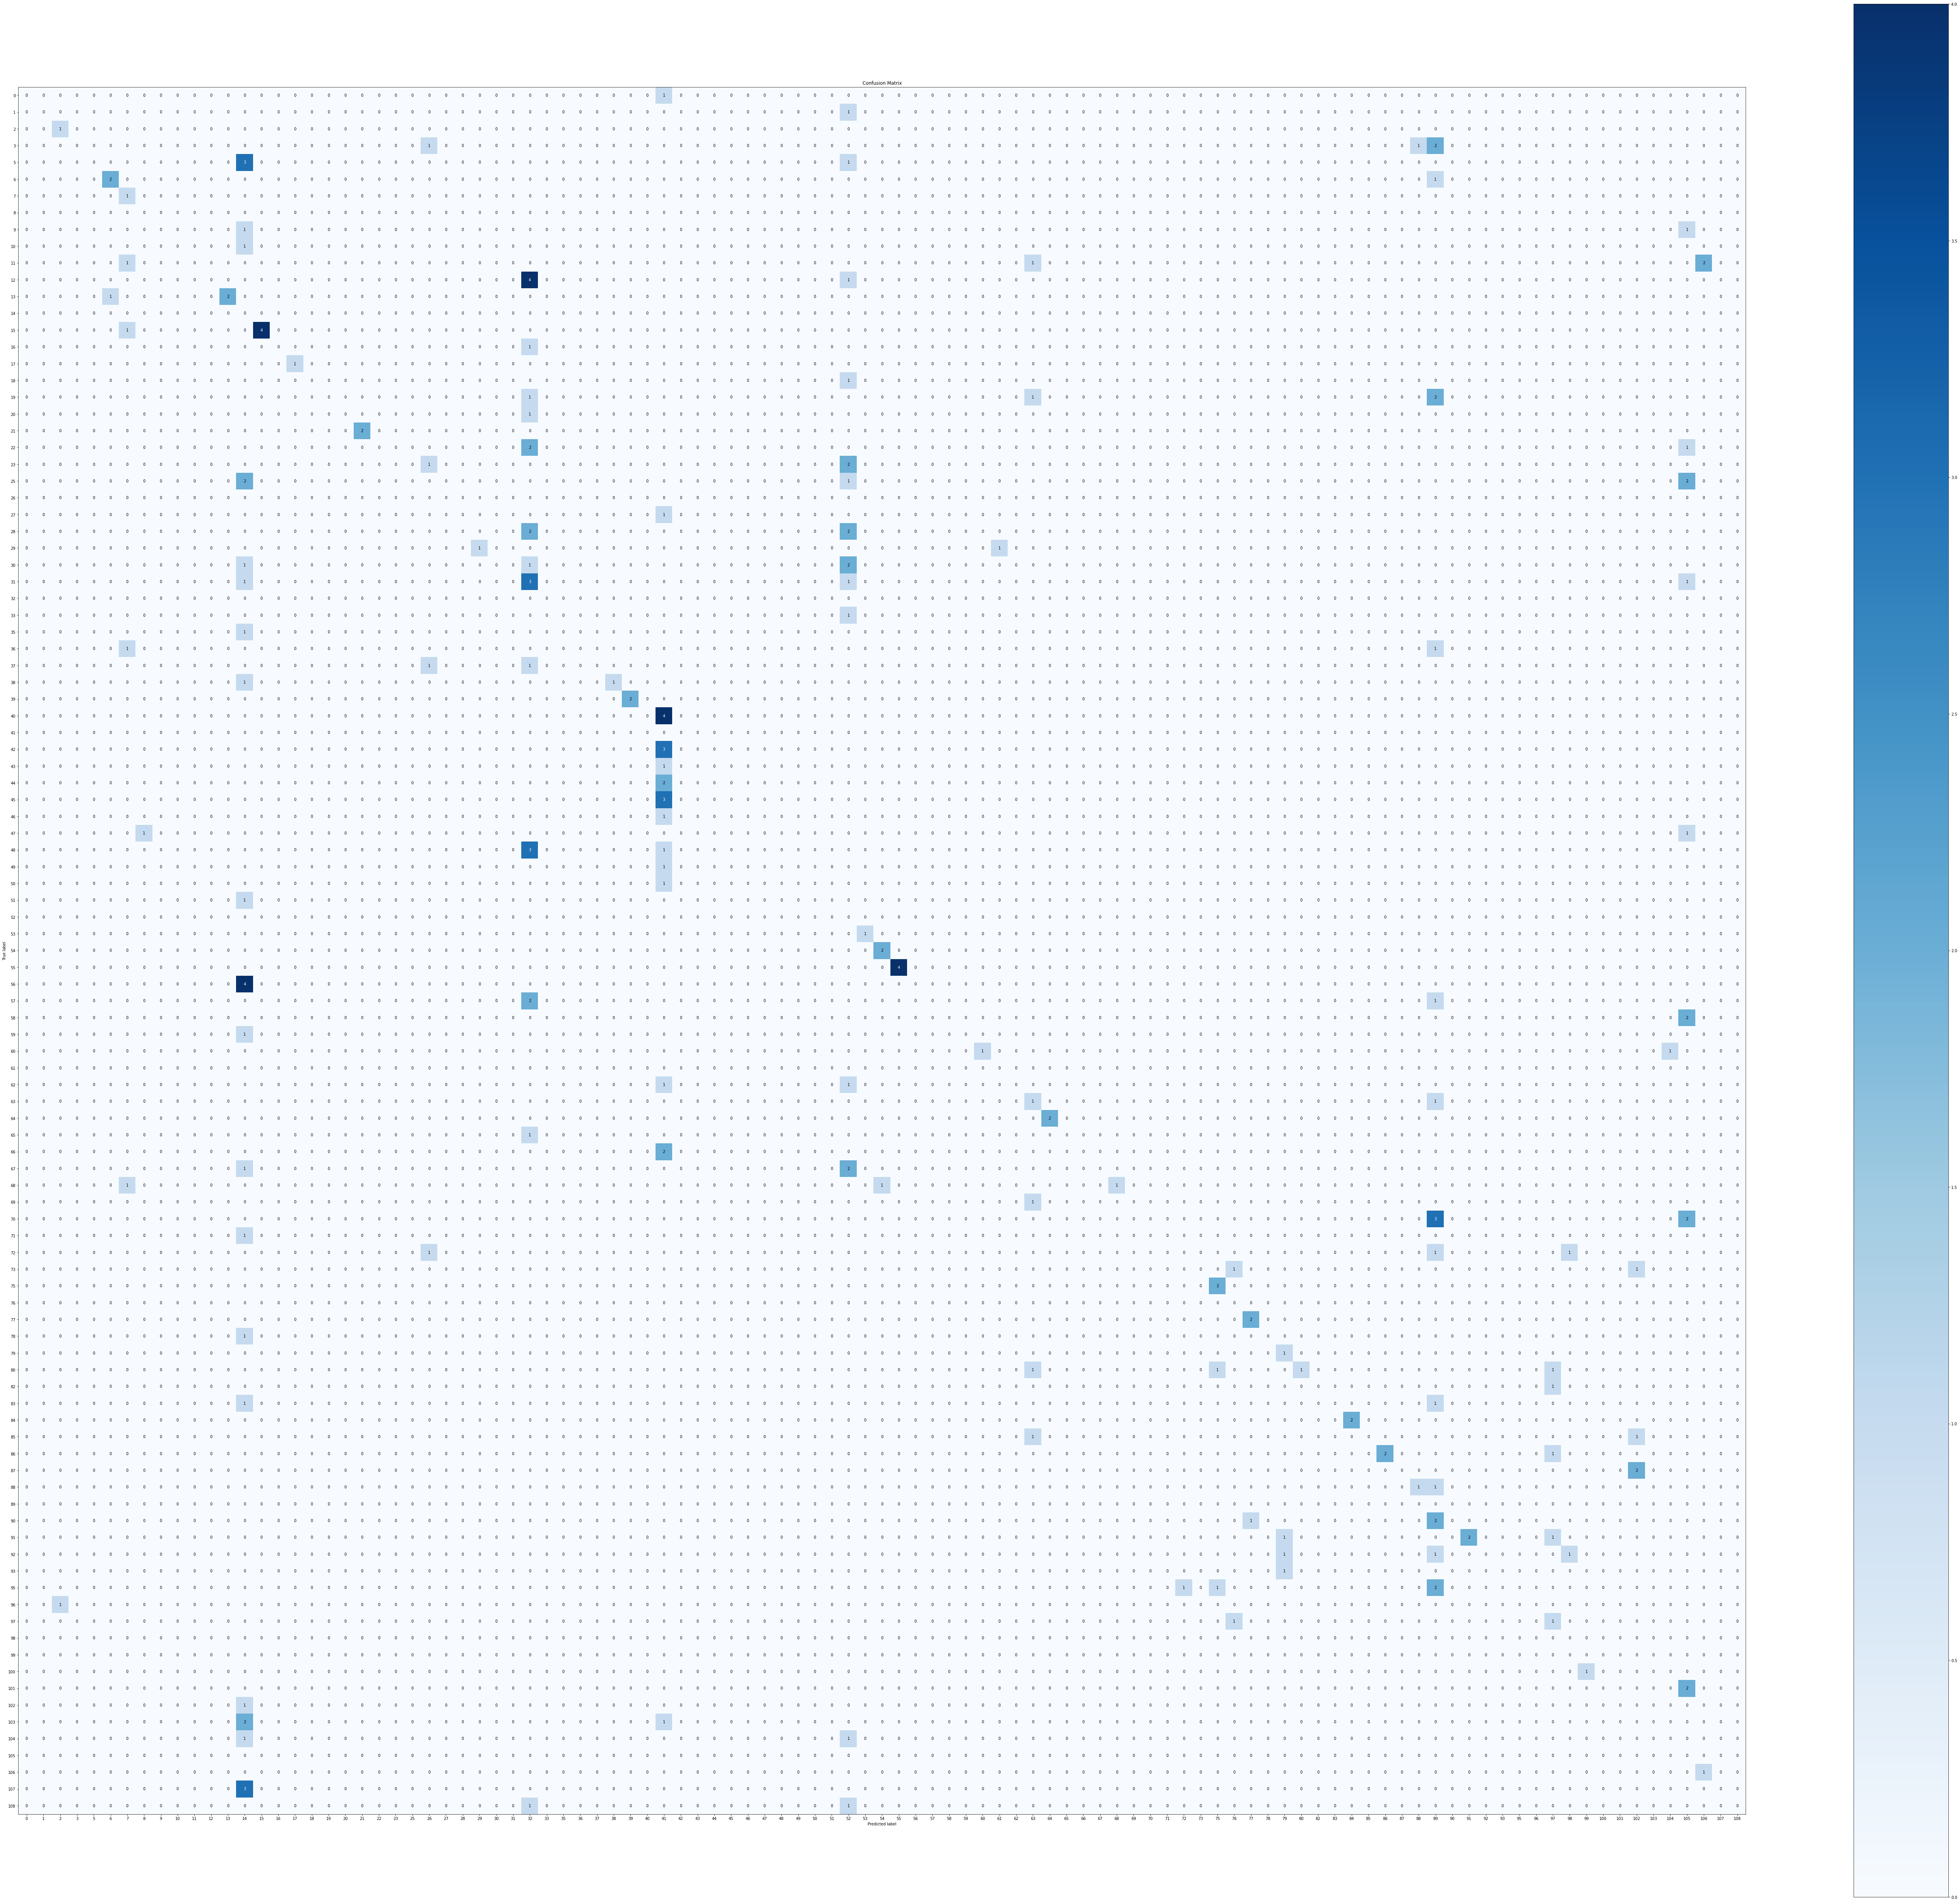

In [141]:
import scikitplot.metrics as splt

splt.plot_confusion_matrix(y_test, y_pred,figsize=(100,90))